<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_SST_file_structure.ipynb" target="_blank"><< Exploring OSI SAF SST product structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_SST_mapping_Geo_SST.ipynb" target="_blank">Mapping Geostationary data satellite >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2026 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?labpath=1_OSI_SAF_sst_introductory%2F1_3a_OSI_SAF_SST_mapping_Global_Metop_SST.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb" target="_blank">1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb</a>**

</div>
<hr>

# 1.3a Mapping Global Metop AVHRR SST products

### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Metop Sea Surface Temperature | EO:EUM:DAT:METOP:GLB-SST-NC | <a href="https://osi-saf.eumetsat.int/products/osi-201-b" target="_blank">Description</a>| OSI-201-b | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Global Metop / AVHRR SST files
* Map SST using cartopy 

### Outline

Now that we've seen how to download the data and how they are structured, we can start ploting them. We will start with the most basic SST plot: **level 3** SST global data, from the **polar orbiting** european satellites **Metop-B**. The satellite almost covers the whole planet in 12h. OSI SAF then provides two Global Metop SST file per day based on AVHRR sensor, timestamped at 00:00UTC and 12:00UTC. For a timestamp H, each file gathers the AVHRR SST retrievals between H-6h and H+6h (the timestamp always correspond to the middle time). This level 3 product is an aggregate of the level 2 products (=granules) that we are going to plot in a <a href="./1_3d_OSI_SAF_SST_mapping_Metop_granules.ipynb" target="_blank">later chapter</a>, as it is a more advanced activity.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>

 1. [Setting parameters](#section1)
 1. [Map SST](#section3)
 
<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import numpy as np                 # a library that supports array manipulation
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_sst` create a plot figure of sea surface temperature of the sst product available in the directory **dir** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_sst(dir, output_projection, cmap, ax=None, title="", region=None): 
    """
    Function to map Sea Surface Temperature. 

    Args:
        dir (string)        : the directory where files are
        output_projection   : the output projection to plot map
        cmap                : color palette
        ax                  : the axis of the plot
        title (sting)       : title of the plot
        region (list)       : the region to zoom in. If not region is given, plot a global map
        
    Returns:
        im                  : the plotting figure

    """
    
    # set data projection
    data_projection=ccrs.PlateCarree()

    # define plot carateristics
    if not ax : ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='dimgrey') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='silver') # Change color of land
    ax.gridlines(draw_labels=True) # Add coasrline
    ax.coastlines('10m') # Draw coastline
    # Select region to zooming 
    if region : 
        ax.set_extent(region, crs=output_projection)
    else :
        ax.set_global()
    
    # Add title
    plt.title(title, fontsize=18)

    # open and plot data
    for filename in os.listdir(dir):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(dir, filename))
            lat = nc.variables['lat'][:]    
            lon = nc.variables['lon'][:]
            sst = nc.variables['sea_surface_temperature'][:]
            ql  = nc.variables['quality_level'][:]
            nc.close()

            # Use only SST with quality_level > 2
            sst_ql345 = np.ma.masked_where(ql<3, sst)
            
            SST = sst_ql345[0,:,:]-273.15
            # plotting sst
            im = plt.pcolormesh(lon, lat, SST, transform=data_projection, cmap=cmap)

            # set the min and max temperature for apropriate visualisation
            im.set_clim(np.nanmin(SST),np.nanmax(SST))
            
    return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('SST [°C]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting parameters
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [4]:
directory = os.path.join(os.getcwd(), 'products', 'L3_Global_Metop')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
We recommend you as well to have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a>. You can use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [5]:
cmap = mpl_cm.get_cmap('RdYlBu_r')
#cmap = mpl_cm.get_cmap('inferno')
#cmap = cmocean.cm.thermal

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Map SST
[Back to top](#TOC-TOP)

</div>

### Global mapping

Let's now map one of the downloaded files onto a global map. We downloaded the Global Metop SST for the same date/time from two different ways, and we saw they do have a different name. Let's start by selecting the GHRSST compliant file name.

In [6]:
keyword = 'OSISAF-L3C_GHRSST'

for filename in os.listdir(directory):
    if filename.endswith(".nc") and keyword in filename:
        nc = xr.open_dataset(os.path.join(directory, filename),decode_timedelta=False)
        print(filename)

20250715000000-OSISAF-L3C_GHRSST-SSTsubskin-AVHRR_SST_METOP_B_GLB-sstglb_metop01_20250715_000000-v02.0-fv01.0.nc


Let's plot the data.

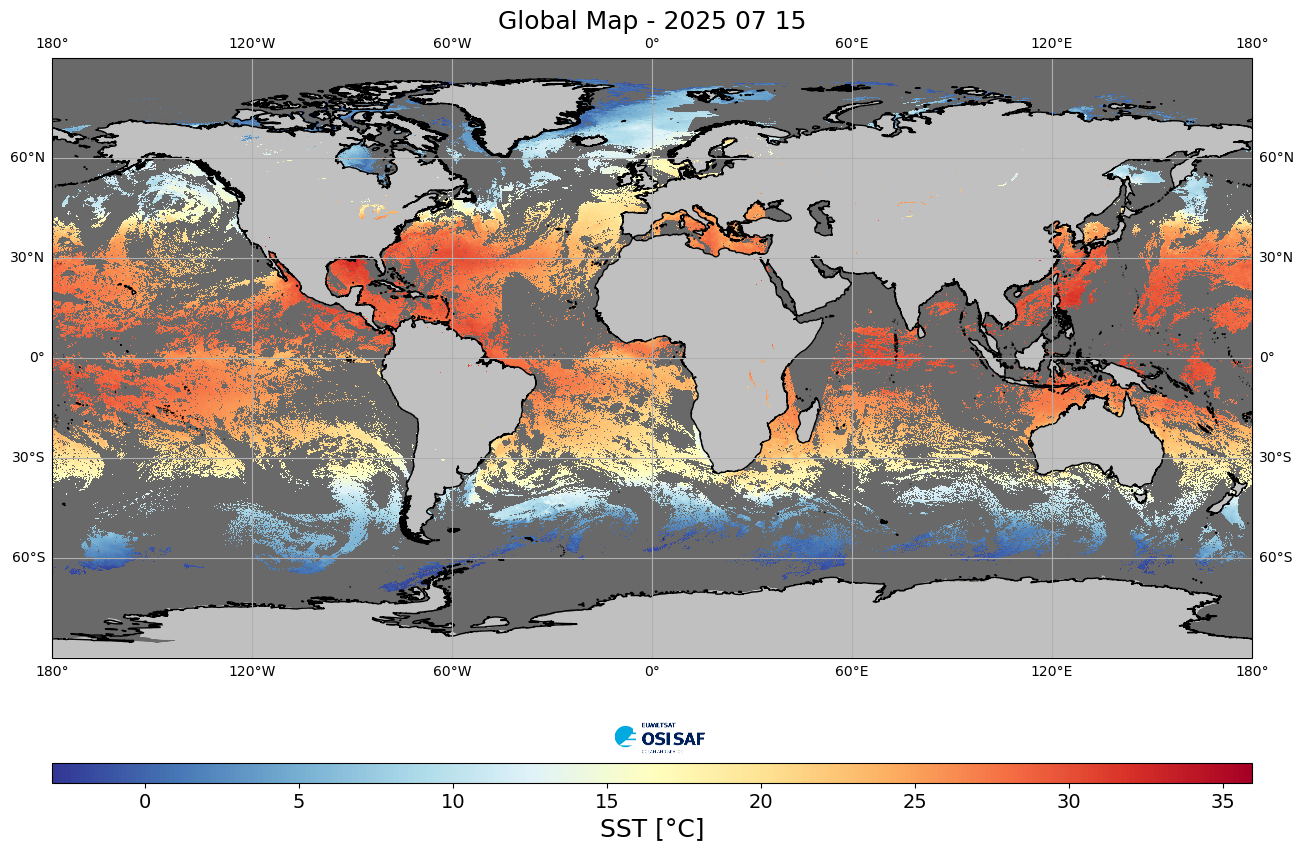

In [7]:

fig = plt.figure(figsize=(16,10))

# request output projection
output_projection=ccrs.PlateCarree()

# define title
title = "Global Map - 2025 07 15"

# Mapping sst
im = mapping_sst(directory, 
                 output_projection,
                 cmap, 
                 title=title)

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

Now we can select the EUMETSAT file name format.

In [8]:
keyword = 'OSISAF-L3C_GHRSST'

for filename in os.listdir(directory):
    if filename.endswith(".nc") and keyword in filename:
        nc = xr.open_dataset(os.path.join(directory, filename),decode_timedelta=False)
        print(filename)

20250715000000-OSISAF-L3C_GHRSST-SSTsubskin-AVHRR_SST_METOP_B_GLB-sstglb_metop01_20250715_000000-v02.0-fv01.0.nc


Let's plot it

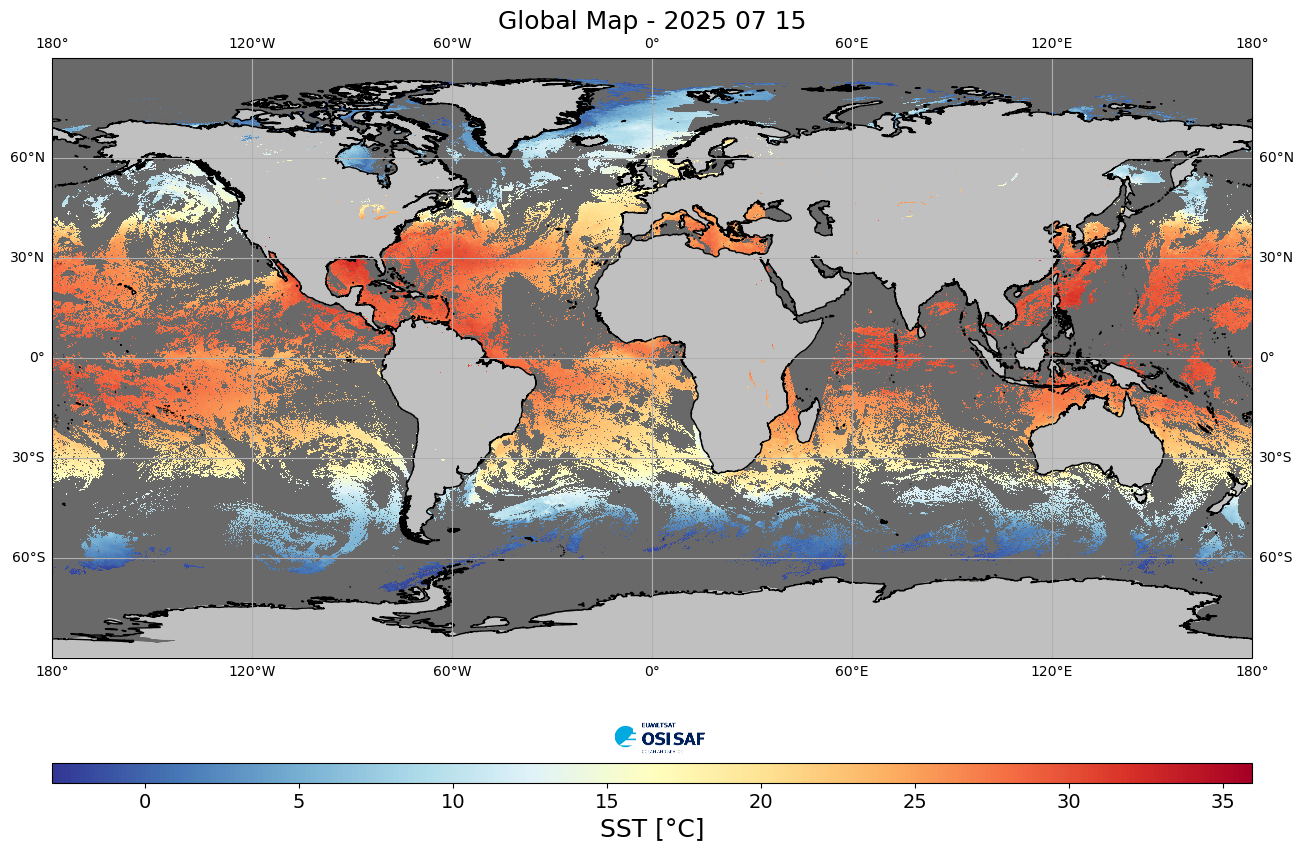

In [9]:
fig = plt.figure(figsize=(16,10))

# request output projection
output_projection=ccrs.PlateCarree()

# define title
title = "Global Map - 2025 07 15"

# Mapping sst
im = mapping_sst(directory, 
                 output_projection,
                 cmap, 
                 title=title)

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

If you compare the two maps, they are strictly indentical, just the name of the file is different.<br>
Being **satellite observations**, the OSI SAF SST files present some gaps: the radiometer can't measure the temperature of the sea through the clouds. We are then masking them. Moreover, as said in introduction, the satellite doesn't cover the whole planet in 12h, consequently our 12h product present a small cone with no measurement. On this file the lack is north of Madagascar (it changes every time, following a 21 days cycle).

### Other type of mapping

We can now try to change the data projection. Code for a wide variety of different projections are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a>. It can be use to visualize our SST products.

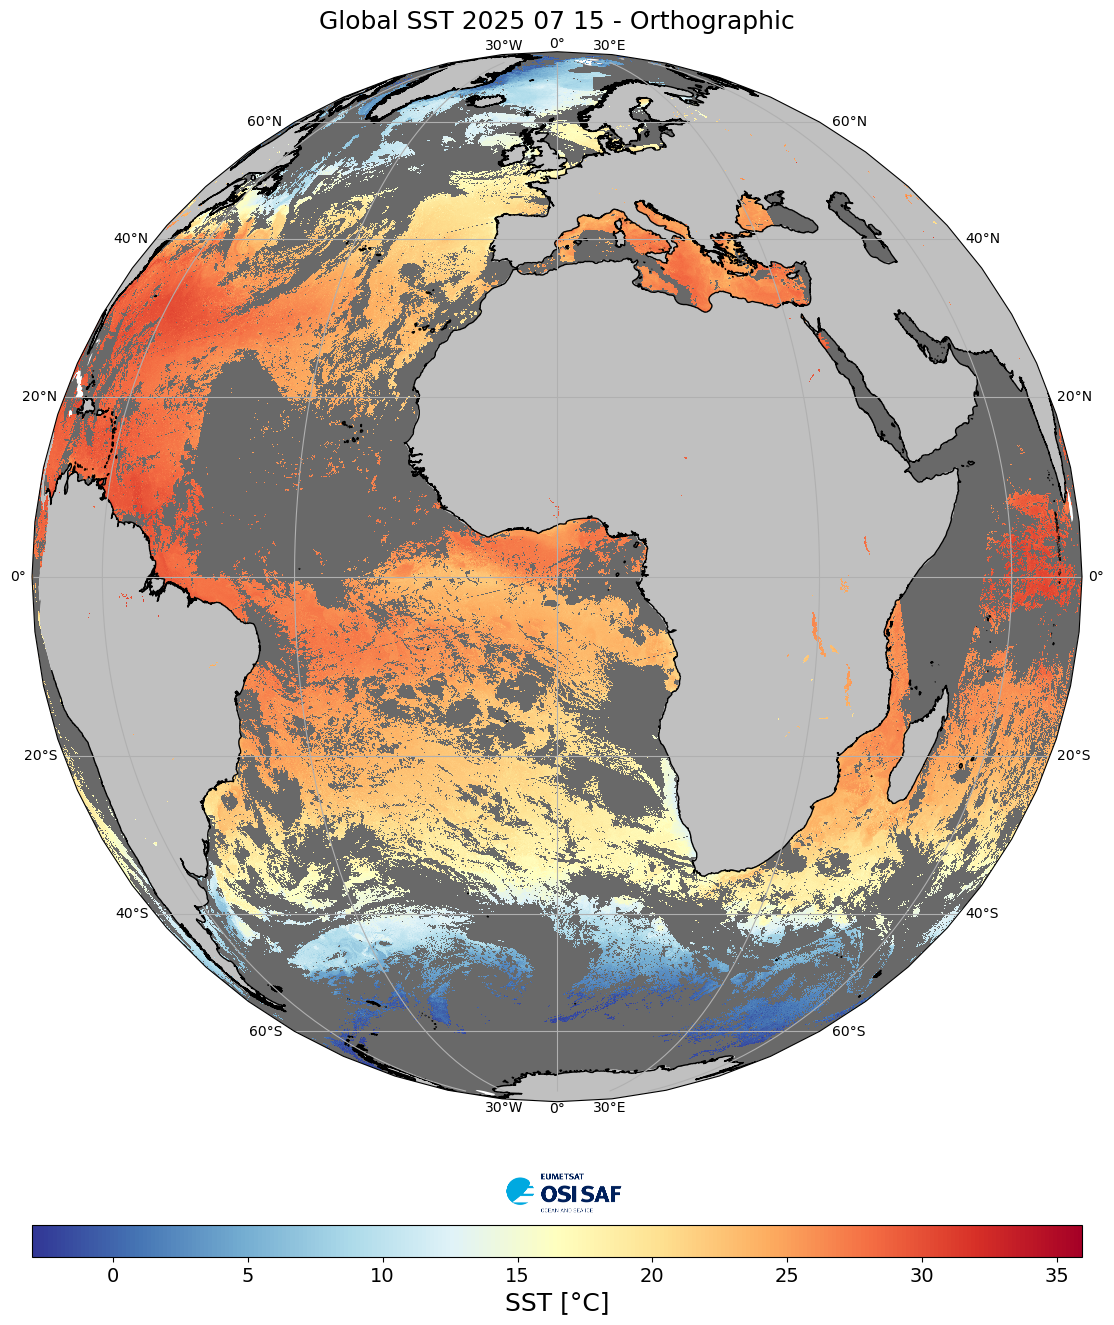

In [10]:
fig = plt.figure(figsize=(14,16))

# request output projection
output_projection=ccrs.Orthographic(central_longitude=0, central_latitude=0)

# define title
title = "Global SST 2025 07 15 - Orthographic"

# Mapping sst
im = mapping_sst(directory,
                 output_projection, 
                 cmap,
                 title=title)

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

### Zoom

In order to visualize a specific area of the globe, we can now use the parameter `region` by adding the extremum of longitude and the extremum of latitude 

Set the geographical area 

In [11]:
# setting geographical area (preset is an example you need to adapt to your data)
lon_min = -90
lon_max = -60
lat_min = 0
lat_max = 30

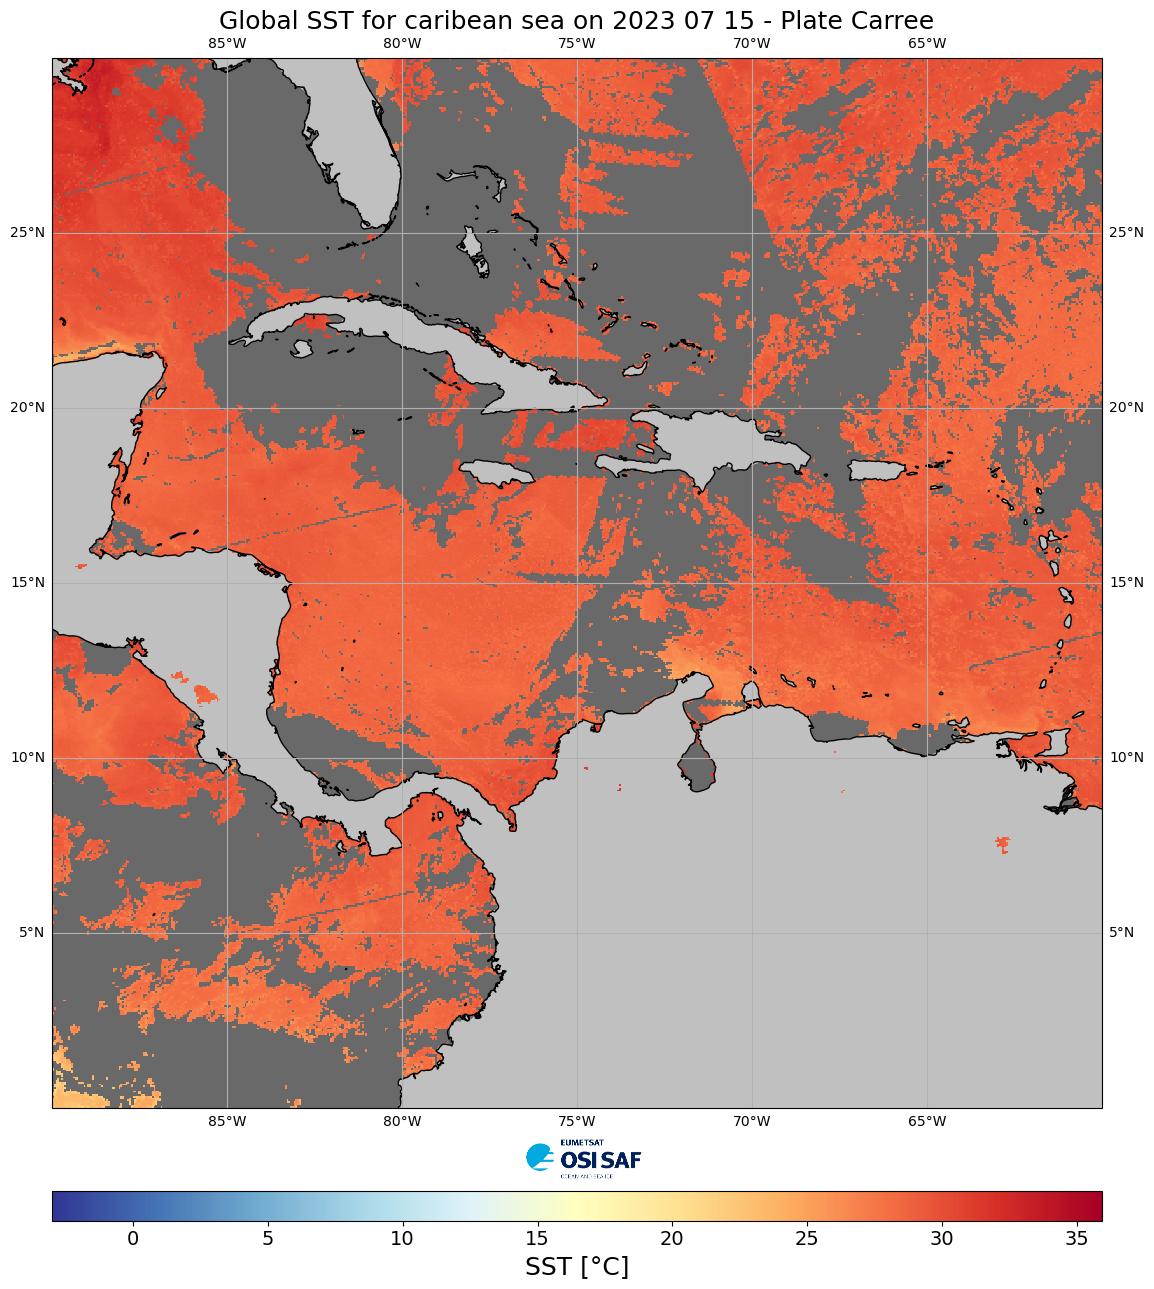

In [12]:
fig = plt.figure(figsize=(14,15))

# request output projection
output_projection=ccrs.PlateCarree()

# define title
title = "Global SST for caribean sea on 2023 07 15 - Plate Carree"

# Mapping sst
im = mapping_sst(directory,
                 output_projection, 
                 cmap,
                 title=title, 
                 region=[lon_min,lon_max,lat_min,lat_max])

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

We've now seen the basics of ploting SST with the most simple case. In the next chapters we will gradually add some particularities with different products types, starting by the **level 3** products from geostationnary satellites.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_SST_file_structure.ipynb" target="_blank"><< Exploring OSI SAF SST product structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_SST_mapping_Geo_SST.ipynb" target="_blank">Mapping Geostationary data satellite >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>